In [40]:
pip install imutils #A series of convenience functions to make basic image processing functions

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=3e6449ae42014fc03e7a6b3fbe12452432f1882b61268a3e423e89c722aa7faf
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


import cv2
import imutils

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

        
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CONFIGURATION

In [2]:
class config:
    dir_data = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

# UTILS

# IMPORT LIBRARY

In [32]:
def load_data(dir_files:str = config.dir_data, 
              img_size:(int, int) = (224, 224)
             ):
    """
        This function creates X_train, X_valid, X_test, y_train, y_valid and y_test set and print labels as encoded
    
    """
    #Create empty list for X_train, X_valid, X_test
    X_train, X_val, X_test = [], [], []
    #Create empty list for y_train, y_valid, y_test
    y_train, y_val, y_test = [], [], []
    
    i = 0
    #Create dictionary to labels
    labels = dict()
    for path in sorted(os.listdir(dir_files)):
        if path.capitalize() == "No" or path.capitalize() == "Yes":
            #Add labels[0]: "No" and labels[1]: "Yes" to labels dict
            labels[i] = path.capitalize()
            #Calculate numebr of images each of has No and Yes Labels
            img_Count = len(os.listdir(os.path.join(dir_files, path)))
            
            for idx, filename in enumerate(os.listdir(os.path.join(dir_files, path))):
                if not filename.startswith("."):
                    #Read the images
                    img = cv2.imread(os.path.join(dir_files, path, filename))
                    #Resize the images
                    img = cv2.resize(img, img_size)
                    if idx < 5:
                        #Append images to X_test
                        X_test.append(img)
                        #Append i value to y_test
                        y_test.append(i)
                    elif idx <= img_Count * 0.8:
                        #Append images to X_train
                        X_train.append(img)
                        #Append images to y_train
                        y_train.append(i)
                        
                    else:
                        #Append images to X_val
                        X_val.append(img)
                        #Append i value to y_val
                        y_val.append(i)
            i += 1
    
    #Change list type to np.array for y_train, y_val, y_test
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    
    #Change list type to np.array for X_train, X_val, X_test
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    
    print(f"Labels encoded as: {labels}")
    print(f"\nTotal count of images are {len(y_train) + len(y_val) + len(y_test)}")
    print(f"\nTrain data set has {len(y_train)} images")
    print(f"\nValidation data set has {len(y_val)} images")
    print(f"\nTest data set has {len(y_test)} images")
    
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test, labels 

In [33]:
X_train, y_train, X_val, y_val, X_test, y_test, labels = load_data(img_size = (264, 264))

Labels encoded as: {0: 'No', 1: 'Yes'}

Total count of images are 253

Train data set has 194 images

Validation data set has 49 images

Test data set has 10 images


# EDA

## Count of Yes and No Labels

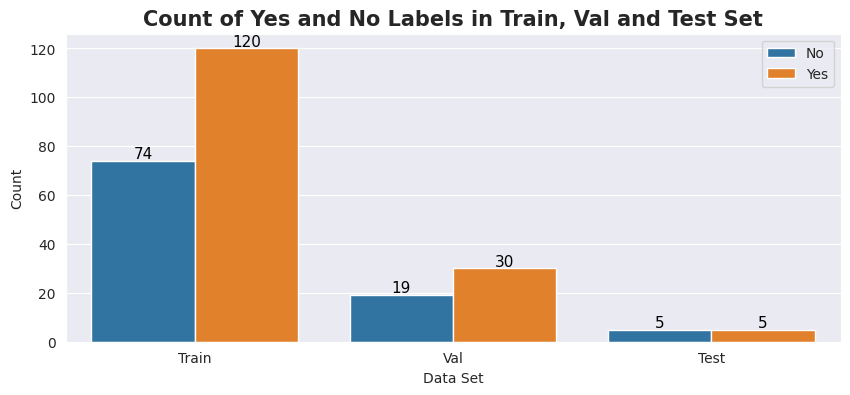

In [34]:
#Create dict for labels
y = {}
#Create lists in dictionary to add 0 and 1 Labels
y[0] = []
y[1] = []

for set_name in (y_train, y_val, y_test):
    #Add count of 0 labels to list
    y[0].append(np.sum(set_name ==0))
    #Add count of 1 labels to list
    y[1].append(np.sum(set_name ==1))

#Create dataframe to plot barplot
a = pd.DataFrame({
    
        "Count": y[0] + y[1],
        "No_yes": ["No", "No", "No", "Yes", "Yes", "Yes"],
        "Data Set": ["Train", "Val", "Test", "Train", "Val", "Test"]
    }
)

#Create figure for graph
plt.figure(figsize = (10, 4))
#Plot barplot 
sns.barplot(data = a, x = "Data Set", y = "Count", hue = "No_yes")
# Add count labels on top of each bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')


#Set title for graph
plt.title("Count of Yes and No Labels in Train, Val and Test Set", weight = "bold", fontsize = 15)
#Place a legend on figure
plt.legend()
#Display graph
plt.show()

- In the train set, mostly yes 

In [28]:
def plot_samples(
                X: np.array,
                y: np.array,
                n: int,
                labels: dict = labels
                
):

    """
        Show the n count of images as a sample
    
    """
    
    for index in range(len(labels)):
        #Take n count of images in X
        imgs = X[np.argwhere(y == index)][:n]
        
        j = 10
        i = int(n/j)
        
        #Create figure for images
        plt.figure(figsize = (15, 8))
        c = 1
        for img in imgs:
            #Use subplot for No and Yes labels
            plt.subplot(i, j, c)
            #Plot images
            plt.imshow(img[0])
            
            #Set x and y labels are empty
            plt.xticks([])
            plt.yticks([])
            #Increase c by 1
            c += 1
        
        #Set title for images
        plt.suptitle(f"Samples of Tumor: {labels[index]}")
        #Display images
        plt.show()

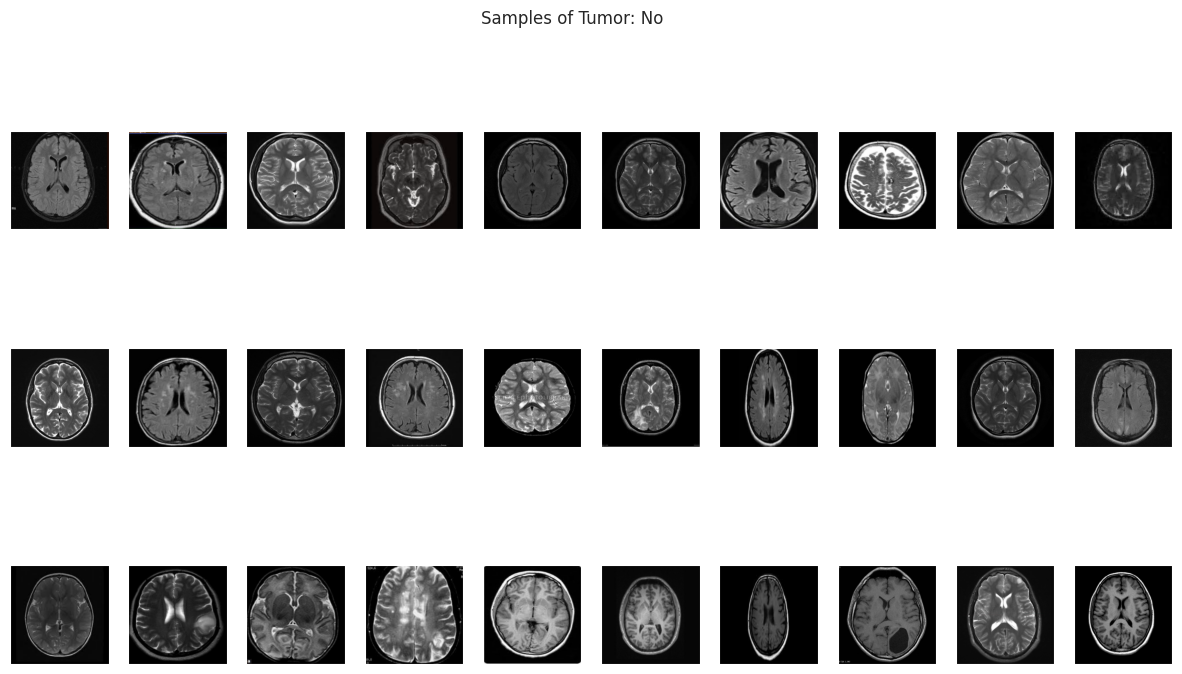

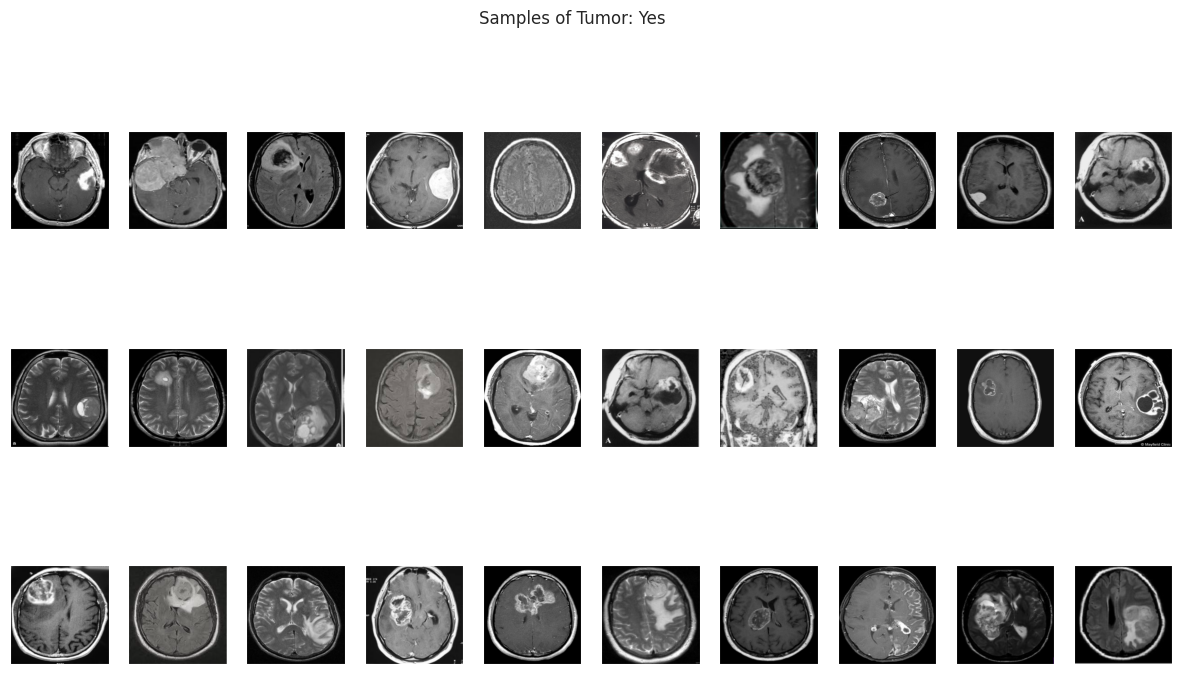

In [29]:
plot_samples(X_train, y_train, 30)

if you remember, he changed the size of all the photos to 264, 264. Now we will crop to make better predictions on these images. VGG 16 models use (224, 224) shape so we are gonna resize the image

## Crop the Image

**What is thresholding?**

Thresholding is the binarization of an image. In general, we seek to convert a grayscale image to a binary image, where the pixels are either 0 or 255.

A simple thresholding example would be selecting a threshold value T, and then setting all pixel intensities less than T to 0, and all pixel values greater than T to 255. In this way, we are able to create a binary representation of the image. [Source](https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/)

**Erode and Dilate**([Source](https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/))

Morphological operations are a set of operations that process images based on shapes. They apply a structuring element to an input image and generate an output image. The most basic morphological operations are two: Erosion and Dilation 
Basics of Erosion: 

- Erodes away the boundaries of the foreground object
- Used to diminish the features of an image.
- Working of erosion: 

    - A kernel(a matrix of odd size(3,5,7) is convolved with the image.
    - A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel are 1, otherwise, it is eroded (made to zero).
    - Thus all the pixels near the boundary will be discarded depending upon the size of the kernel. So the thickness or size of the foreground object decreases or simply the white region decreases in the image.
    
Basics of dilation: 

- Increases the object area
- Used to accentuate features
- Working of dilation:

    - A kernel(a matrix of odd size(3,5,7) is convolved with the image
    - A pixel element in the original image is ‘1’ if at least one pixel under the kernel is ‘1’.
    - It increases the white region in the image or the size of the foreground object increases 
    
    
**Contours** ([Source](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html))

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.



### Sample for Crop Image

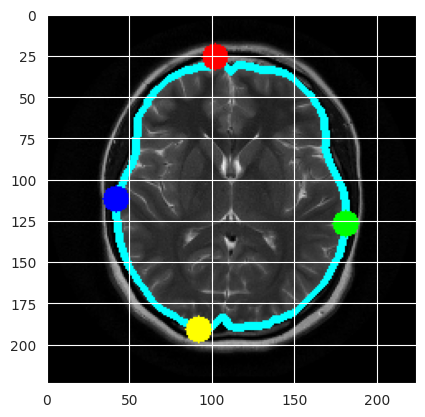

In [49]:
#Determine image size to models
img_size = (224, 224)
img = cv2.imread(os.path.join(
    config.dir_data, 
    "no", 
    "1 no.jpeg"))
#Change size of image
img = cv2.resize(img,
                dsize = img_size,
                interpolation = cv2.INTER_CUBIC # This is slow but more efficient.
                )

#Convert an image from one color space to another.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#Apply Gaussian Smoothing on the mage
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

#find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(),
                       cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE #It removes all redundant points and compresses the contour, thereby saving memory.
                       )
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


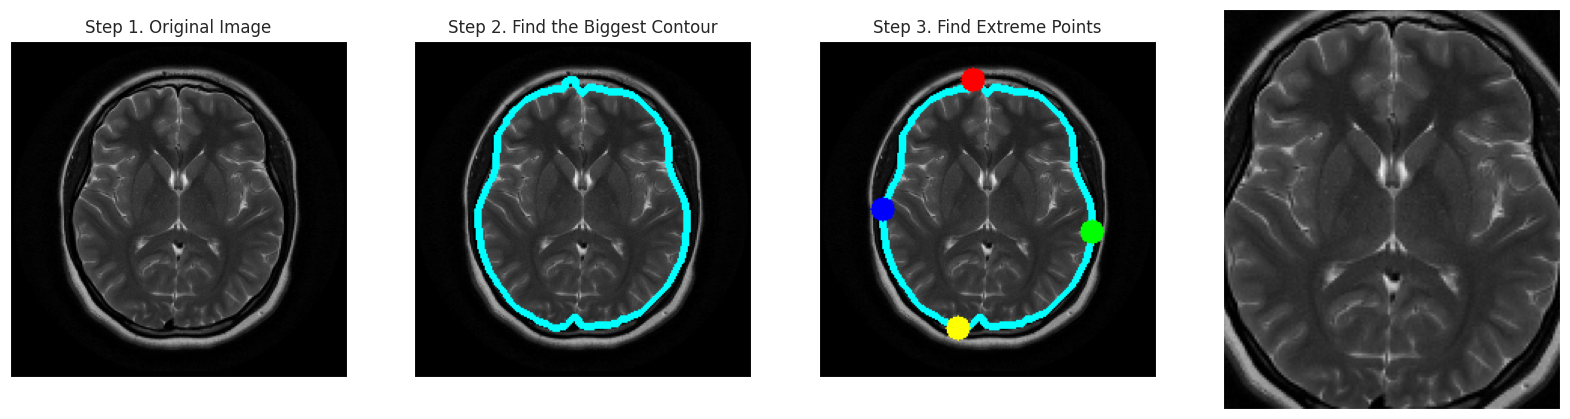

In [51]:
#Create figur efor graph
plt.figure(figsize = (20, 6))
#Select subplot to plot original image
plt.subplot(141)
#Plot original image
plt.imshow(img)
#Set a title for original image
plt.title("Step 1. Original Image")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot Biggest  Contours
plt.subplot(142)
#Plot Biggest Contours image
plt.imshow(img_cnt)
#Set a title for Biggest Contours image
plt.title("Step 2. Find the Biggest Contour")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot Extreme Points
plt.subplot(143)
#Plot extreme points
plt.imshow(img_pnt)
#Set a title for extreme points
plt.title("Step 3. Find Extreme Points")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot cropped image
plt.subplot(144)
#Plot cropped image
plt.imshow(new_img)
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Dispaly images
plt.show()

### Crop Images

In [56]:
def crop_imgs(set_name, 
              add_pixels_value: int =0,
              img_size: (int, int) = (224, 224)
             ):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        #Change size of image
        img = cv2.resize(img,
                        dsize = img_size,
                        interpolation = cv2.INTER_CUBIC # This is slow but more efficient.
                        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [57]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (194,) + inhomogeneous part.